Epoch 1/100, Total Loss: 35.6579, Reconstruction Loss: 3.0052, Classification Loss: 68.3106
Epoch 2/100, Total Loss: 33.3046, Reconstruction Loss: 1.4080, Classification Loss: 65.2012
Epoch 3/100, Total Loss: 32.3991, Reconstruction Loss: 1.2520, Classification Loss: 63.5461
Epoch 4/100, Total Loss: 32.0500, Reconstruction Loss: 1.2003, Classification Loss: 62.8996
Epoch 5/100, Total Loss: 31.8480, Reconstruction Loss: 1.2223, Classification Loss: 62.4738
Epoch 6/100, Total Loss: 31.7248, Reconstruction Loss: 1.2572, Classification Loss: 62.1923
Epoch 7/100, Total Loss: 31.7460, Reconstruction Loss: 1.3151, Classification Loss: 62.1768
Epoch 8/100, Total Loss: 31.5217, Reconstruction Loss: 1.2697, Classification Loss: 61.7737
Epoch 9/100, Total Loss: 31.6110, Reconstruction Loss: 1.3504, Classification Loss: 61.8716
Epoch 10/100, Total Loss: 31.4582, Reconstruction Loss: 1.3228, Classification Loss: 61.5935
Epoch 11/100, Total Loss: 31.3715, Reconstruction Loss: 1.3144, Classification 

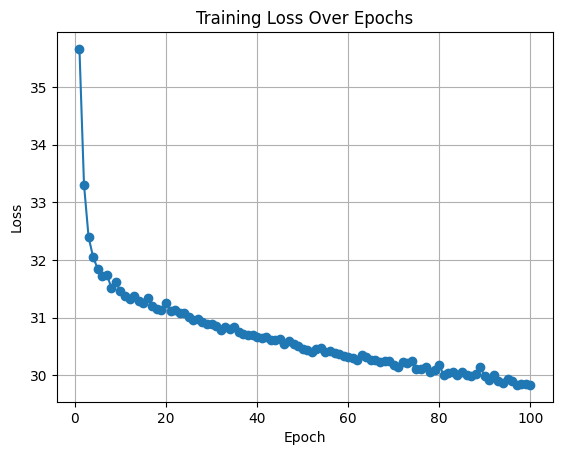

Test Accuracy: 0.8210
Test AUC: 0.7561
Test KS Statistic: 0.4400


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pennylane as qml

# Load the UCI dataset
df = pd.read_csv('default_dataset.csv')

# Sample 5000 rows
df = df.sample(5000, random_state=42)

# Separate X and y, dropping non-useful columns
X = df.drop(['default.payment.next.month', 'ID'], axis="columns")
y = df['default.payment.next.month']

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

# Quantum circuit definition
n_qubits = 2
latent_dim = 2  
n_layers = 3 # Number of layers in the variational ansatz

def quantum_circuit(params, features):
    qml.AngleEmbedding(features, wires=range(n_qubits), rotation='Y')
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RY(params[layer, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    return qml.expval(qml.PauliZ(0))

# Quantum node and hybrid model
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_node(features, params):
    return quantum_circuit(params, features)

class VQC(nn.Module):
    def __init__(self, latent_dim, n_qubits, n_layers):
        super(VQC, self).__init__()
        self.latent_dim = latent_dim
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.params = nn.Parameter(torch.randn(n_layers, n_qubits, dtype=torch.float64))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x_split = torch.chunk(x, chunks=self.latent_dim // self.n_qubits, dim=1)
        outputs = []
        for x_sub in x_split:
            outputs.append(quantum_node(x_sub, self.params))
        raw_output = torch.stack(outputs, dim=1).mean(dim=1, keepdim=True)
        return self.sigmoid(raw_output)  # Apply sigmoid to constrain output between 0 and 1

# Combined loss function
class GuidedQuantumCompression(nn.Module):
    def __init__(self, autoencoder, vqc, lambda_param):
        super(GuidedQuantumCompression, self).__init__()
        self.autoencoder = autoencoder
        self.vqc = vqc
        self.lambda_param = lambda_param
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, x, y):
        z, x_reconstructed = self.autoencoder(x)
        y_pred = self.vqc(z)
        reconstruction_loss = self.mse_loss(x_reconstructed, x)
        classification_loss = self.bce_loss(y_pred, y)
        return (1 - self.lambda_param) * reconstruction_loss + self.lambda_param * classification_loss

# Model initialization
input_dim = X_train.shape[1]
lambda_param = 0.5

autoencoder = Autoencoder(input_dim, latent_dim).double()
vqc = VQC(latent_dim, n_qubits, n_layers).double()
model = GuidedQuantumCompression(autoencoder, vqc, lambda_param).double()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 100
batch_size = 32
X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64).view(-1, 1)

data_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True
)

loss_history = []
for epoch in range(n_epochs):
    total_loss = 0
    reconstruction_loss = 0
    classification_loss = 0
    for batch_x, batch_y in data_loader:
        optimizer.zero_grad()
        z, x_reconstructed = autoencoder(batch_x)
        y_pred = vqc(z)

        # Fix: Use MSELoss directly instead of referring to the autoencoder
        recon_loss = nn.MSELoss()(x_reconstructed, batch_x)
        class_loss = model.bce_loss(y_pred, batch_y)
        loss = (1 - lambda_param) * recon_loss + lambda_param * class_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        reconstruction_loss += recon_loss.item()
        classification_loss += class_loss.item()
    loss_history.append(total_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Total Loss: {total_loss:.4f}, "
          f"Reconstruction Loss: {reconstruction_loss:.4f}, Classification Loss: {classification_loss:.4f}")

# Plot training loss
plt.plot(range(1, n_epochs + 1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()

# Evaluation
X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64).view(-1, 1)
z_test, _ = autoencoder(X_test_tensor)
preds = vqc(z_test)
preds_probs = preds.detach().numpy()
preds_binary = (preds_probs > 0.5).astype(float)

accuracy = (preds_binary == y_test_tensor.numpy()).mean()
auc_score = roc_auc_score(y_test_tensor.numpy(), preds_probs)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc_score:.4f}")

# Compute KS (Kolmogorov-Smirnov) metric
fpr, tpr, thresholds = roc_curve(y_test_tensor.numpy(), preds_probs)
ks_statistic = np.max(np.abs(fpr - tpr))
print(f"Test KS Statistic: {ks_statistic:.4f}")
